In [103]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [104]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [105]:
x = np.zeros((5000,2))

In [106]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

In [107]:
x[idx[0]][0], x[idx[5]][5] 

(array([4.04729858, 6.43185741]), array([3.4612816 , 8.00144771]))

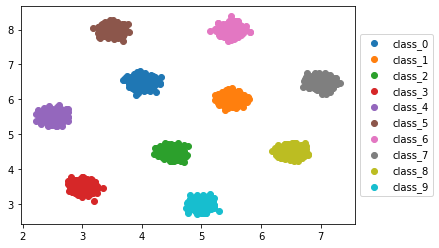

In [108]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [109]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [110]:
np.unique(bg_idx).shape

(3513,)

In [111]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [112]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-3.94054906e-15, -1.42341147e-15]]),
 array([[-0.02477713,  0.03899959]]))

In [113]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [114]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[0.86429775, 0.8750994 ]]))

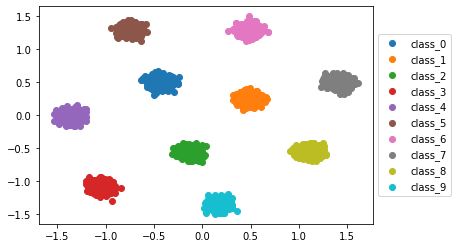

In [115]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [116]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [117]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,10)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
foreground 2 present at 2
background 5 present at 3
background 3 present at 4
background 5 present at 5
background 7 present at 6
background 6 present at 7
background 5 present at 8
(9, 2)
2 2


In [118]:
a.shape

(9, 2)

In [119]:
np.reshape(a,(18,1))

array([[-0.75222128],
       [ 1.29671369],
       [ 0.42676916],
       [ 1.30247133],
       [-0.11686808],
       [-0.56478963],
       [-0.67891371],
       [ 1.27937091],
       [-0.99259119],
       [-1.18031499],
       [-0.77179291],
       [ 1.25941783],
       [ 1.29283021],
       [ 0.50509151],
       [ 0.52239625],
       [ 1.29681995],
       [-0.77179291],
       [ 1.25941783]])

In [120]:
a=np.reshape(a,(3,6))

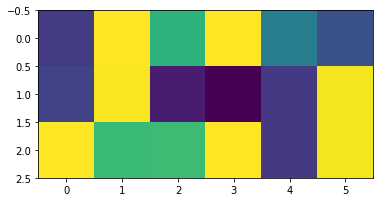

In [121]:
plt.imshow(a)

In [122]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(18,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [123]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [124]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((2000, 18),
 array([-0.3812813 ,  0.44382682,  0.47763291,  1.25059329,  0.54230705,
         1.29438001, -1.30547943, -0.083791  ,  1.10227457, -0.5565904 ,
         1.44996512,  0.52630897,  0.18635473, -1.38666417, -1.04928029,
        -1.12467272, -0.78873321,  1.29405413]))

In [125]:
for j in range(9):
  print(mosaic_list_of_images[0][2*j:2*j+2])
  

[-0.3812813   0.44382682]
[0.47763291 1.25059329]
[0.54230705 1.29438001]
[-1.30547943 -0.083791  ]
[ 1.10227457 -0.5565904 ]
[1.44996512 0.52630897]
[ 0.18635473 -1.38666417]
[-1.04928029 -1.12467272]
[-0.78873321  1.29405413]


In [126]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([2], dtype=torch.float64)
    np.random.seed(int(dataset_number*10000 + i))
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(9):
      if j == give_pref:
        img = img + mosaic_dataset[i][2*j:2*j+2]*dataset_number/9   #2 is data dim
      else :
        img = img + mosaic_dataset[i][2*j:2*j+2]*(9-dataset_number)/(8*9)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [127]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.4)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.6)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.8)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.2)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.4)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.6)
avg_image_dataset_10 , labels_10,  fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.8)

test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000], fore_idx[1000:2000] , 9)

number of correct averaging happened for dataset 0 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.2 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.4 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.6 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.8 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 1 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 1.2 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 1.4 is 100

In [128]:
avg = torch.stack(avg_image_dataset_1, axis = 0)
avg_image_dataset_1 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_2, axis = 0)
avg_image_dataset_2 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_2, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_2, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_3, axis = 0)
avg_image_dataset_3 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_3, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_3, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_4, axis = 0)
avg_image_dataset_4 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_4, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_4, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_5, axis = 0)
avg_image_dataset_5 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_5, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_5, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_6, axis = 0)
avg_image_dataset_6 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_6, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_6, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_7, axis = 0)
avg_image_dataset_7 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_7, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_7, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_8, axis = 0)
avg_image_dataset_8 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_8, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_8, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_9, axis = 0)
avg_image_dataset_9 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_9, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_9, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_10, axis = 0)
avg_image_dataset_10 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_10, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_10, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(test_dataset, axis = 0)
test_dataset = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(test_dataset, keepdims= True, axis = 0))
print(torch.std(test_dataset, keepdims= True, axis = 0))
print("=="*40)


tensor([[1.0658e-17, 7.1054e-18]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[-1.7764e-17,  1.7764e-17]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[ 0.0000e+00, -1.7764e-17]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[-2.8422e-17, -3.5527e-18]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[3.5527e-18, 1.4211e-17]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[-1.7764e-17, -1.0658e-17]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[3.5527e-18, 1.4211e-17]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[-1.0658e-17, -3.5527e-18]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[3.5527e-18, 3.5527e-17]], dtype=torch.float64)
tensor([[1.0000, 1.0000]], dtype=torch.float64)
tensor([[-2.1316e-17, -3.5527e-17]], dtype=torch.float

Text(0.5, 1.0, 'type 2 alpha = 0.4/9')

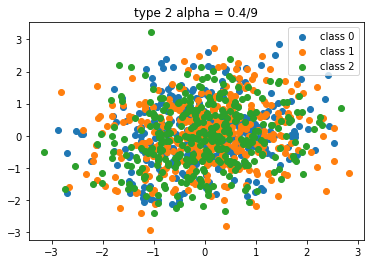

In [129]:
x1 = (avg_image_dataset_3).numpy()
y1 = np.array(labels_3)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("type 2 alpha = 0.4/9")

Text(0.5, 1.0, 'type 2 alpha = 1/9')

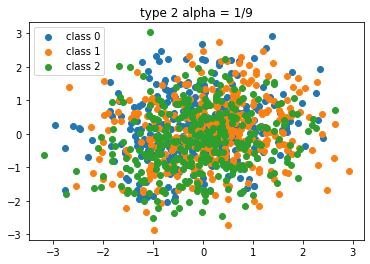

In [130]:
x1 = (avg_image_dataset_6).numpy()
y1 = np.array(labels_6)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("type 2 alpha = 1/9")

Text(0.5, 1.0, 'type 2 alpha = 1.6/9')

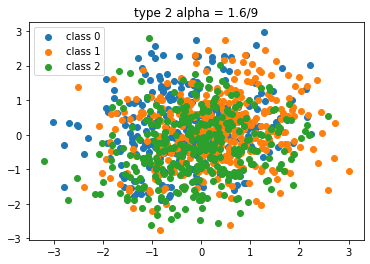

In [131]:
x1 = (avg_image_dataset_9).numpy()
y1 = np.array(labels_9)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("type 2 alpha = 1.6/9")

Text(0.5, 1.0, 'type 2 alpha = 1.8/9')

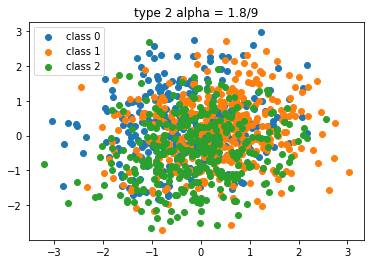

In [132]:
x1 = (avg_image_dataset_10).numpy()
y1 = np.array(labels_10)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("type 2 alpha = 1.8/9")

In [133]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [134]:
avg_image_dataset_1[0].shape
avg_image_dataset_1[0]

tensor([0.2173, 0.3625], dtype=torch.float64)

In [135]:
l = [ labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10]
for i in l:
  print(np.unique(l))

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]


In [136]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

In [137]:
testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)



In [138]:
testdata_11 = MosaicDataset(test_dataset, labels )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [139]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,50)
        self.linear2 = nn.Linear(50,10)
        self.linear3 = nn.Linear(10,3)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = (self.linear3(x))

        return x

In [140]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/i

In [141]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the 1000 test dataset %d: %.2f %%' % (number , 100 * correct / total))

In [142]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.0009 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%500 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 1000 train images: %.2f %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi
    

In [143]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10, testloader_11]

In [144]:
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))
train_loss_all.append(train_all(trainloader_10, 10, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
epoch: [0 ] loss: 1.384
epoch: [1] loss: 1.380
epoch: [501] loss: 1.336
Finished Training
Accuracy of the network on the 1000 train images: 41.50 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  415 total  1000
Accuracy of the network on the 1000 test dataset 1: 41.50 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  415 total  1000
Accuracy of the network on the 1000 test dataset 2: 41.50 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  406 total  1000
Accuracy of the network on the 1000 test dataset 3: 40.60 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  401 total  1000
Accuracy of the network on the 1000 test dataset 4: 40.10 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  394 total  1000
Accuracy of the network on the 1000 test dataset 5: 39.40 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  392 total  1000
Accuracy of the network on the 1

In [145]:
%matplotlib inline

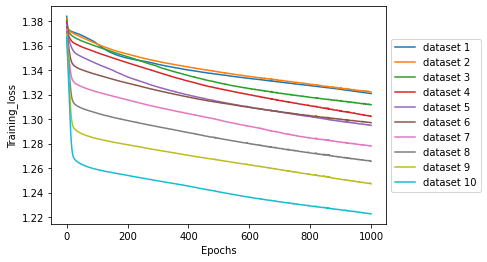

In [146]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))